# Прогноз цен на жильё на DataWorkshop

Поскольку самих трейн и тест данных нет, будем ориентироваться на ощупь и по памяти

In [9]:
#  Импортируем нужные библиотеки

import pandas as pd
import numpy as np
import helper as h
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
#import eli5
from tqdm import tqdm
#import seaborn as sns
import gc

In [10]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    """
    Функция из стартера для проверки модели
    
    :param df: загружаемый датафрейм
    :param feats: целевая переменная
    :param model: проверяемая модель
    :param cv: насколько частей делим датафрейм для кросс-валидации
    :param scoring: что оптимизируем
    """
    df_train = df[ ~df["price"].isnull() ].copy()
    df_test = df[ df["price"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price"]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)

In [11]:
def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    """
    Функция из стартера для проверки модели, но с логарифмом целевой переменной
    
    :param df: загружаемый датафрейм
    :param feats:
    :param model: проверяемая модель
    :param cv: насколько частей делим датафрейм для кросс-валидации
    :param scoring: что оптимизируем
    """
    
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [13]:
#  Загружаем данные, устанавливаем целевую переменную и складываем датасеты, 
#  чтобы не обрабатывать в трейне и тесте данные два раза

df_train = pd.read_hdf("../input/train_data.h5")
df_train['price'] = df_train['price'].map(h.parse_price)

df_test = pd.read_hdf("../input/test_data.h5")

print(df_train.shape, df_test.shape)

df = pd.concat([df_train, df_test])

(11448, 2)


In [288]:
#  Айдишку убираем в индекс. Кроме индекса толку от неё нет

df = df.set_index('id')

In [289]:
#  В params лежал словарь с разными дополнительными данными о квартире:
#  Наличие охраны, детской площадки, тип дома, новостройка или нет и так далее
#  Мы их разбрираем в датафрейм и клеим к основному датафрейму

params = df["params"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df:
    df = pd.concat([df, params], axis=1)

In [290]:
#  Общая площадь в формате "55.5 м"
#  Разбираем строку по пробелу и берем первый элемент, переводя данные в формат float

df['Общая площадь:'] = df['Общая площадь:'].apply(lambda x: float(x.split(' ')[0]))

In [291]:
#  Комиссию агенту я преобразовал из идеи: "На сколько будет домножена стоимость при выплате комиссии"

df['Комиссия агенту:'] = df['Комиссия агенту:'].replace({'без комиссии': 1,
                                                         -1: 1,
                                                         '1%': 1.01,
                                                         '10%': 1.1,
                                                         '3%': 1.03,
                                                         '2%': 1.02})

In [292]:
#  Высота потолко, площадь кухни, жилая комната в формате "55.5 м"
#  Разбираем строку по пробелу и берем первый элемент, переводя данные в формат float
#  В пропущенные значения кладём медиану

df['Высота потолков:'] = df['Высота потолков:'].replace({-1: '-1'})
df['Высота потолков:'] = df['Высота потолков:'].apply(lambda x: float(x.split(' ')[0]))
df['Высота потолков:'] = df['Высота потолков:'].replace({-1.00: df['Высота потолков:'].median()})

df['Площадь кухни:'] = df['Площадь кухни:'].replace({-1: '-1'})
df['Площадь кухни:'] = df['Площадь кухни:'].apply(lambda x: float(x.split(' ')[0]))
df['Площадь кухни:'] = df['Площадь кухни:'].replace({-1.00: df['Площадь кухни:'].median()})

df['Жилая комната:'] = df['Жилая комната:'].replace({-1: '-1'})
df['Жилая комната:'] = df['Жилая комната:'].apply(lambda x: float(x.split(' ')[0]))
df['Жилая комната:'] = df['Жилая комната:'].replace({-1.00: df['Жилая комната:'].median()})

In [295]:
#  Этаж в формате "этаж / из"
#  Разбиваем строку по /, берем первый элемент
#  Преобразовать отсутствующие значения я забыл :) 

df['Этаж:'] = df['Этаж:'].replace({-1: '-1'})
df['Этаж:'] = df['Этаж:'].apply(lambda x: int(x.split('/')[0]))

In [296]:
#  Бинарники я кодировл так: если значение пропущено, значит, False
#  В категориальные переменные укладывал самое часто встречаемое значение
#  В каких-то случаях делал просто по интуиции: как я понял данные

df['Детская площадка:'] = df['Детская площадка:'].replace({-1: False, 'Есть': True})
df['Возможна ипотека:'] = df['Возможна ипотека:'].replace({'да': True, -1: False})
df['Лифт:'] = df['Лифт:'].replace({'да': True, -1: False})
df['Мебель на кухне:'] = df['Мебель на кухне:'].replace({'да': True, -1: False})
df['Мусоропровод:'] = df['Мусоропровод:'].replace({'да': True, -1: False})
df['Холодильник:'] = df['Холодильник:'].replace({'да': True, -1: False})
df['Ремонт:'] = df['Ремонт:'].replace({-1: 'без отделки',
                                       'без ремонта': 'без отделки',
                                       'с отделкой': 'косметический'})
df['Тип санузла:'] = df['Тип санузла:'].replace({-1: 'раздельный'})
df['Тип балкона:'] = df['Тип балкона:'].replace({-1: 'нет'})
df['Интернет:'] = df['Интернет:'].replace({'да': True, -1: False})
df['Мебель:'] = df['Мебель:'].replace({'да': True, -1: False})
df['Телефон:'] = df['Телефон:'].replace({'да': True, -1: False})
df['Свободная планировка:'] = df['Свободная планировка:'].replace({-1: 'нет'})
df['Покрытие пола:'] = df['Покрытие пола:'].replace({-1: 'ламинат'})
df['Возможен торг:'] = df['Возможен торг:'].replace({'да': True, -1: False})
df['Элитный'] = df['Класс:'].replace({-1: False, 'элитная недвижимость': True})
df['Телевизор:'] = df['Телевизор:'].replace({'да': True, -1: False})
df['Стиральная машина:'] = df['Стиральная машина:'].replace({'да': True, -1: False})
df['Предоплата:'] = df['Предоплата:'].replace({-1: 0, 100: 1, 10: 0.1, 1: 100})
df['Количество корпусов:'] = df['Количество корпусов:'].replace({-1: 0})
df['Количество жилых помещений:'] = df['Количество жилых помещений:'].replace({-1: 152})

In [297]:
#  Убрал выбросы по площади

df = df[(df['Общая площадь:'] < 1000)]

In [298]:
#  breadcrumbs разобрал по типу params, но уже не заморочился с преобразованием того, что вышло

breadcrumbs = df['breadcrumbs'].apply(pd.Series).fillna(-1)

In [300]:
#  Джоиним с основным датафреймом, скидываем лишние колонки

df = df.merge(breadcrumbs, left_index=True, right_index=True)
df = df.drop(['params', 'breadcrumbs', 'user_block', 'date', 'owner'], axis=1)

In [301]:
#  Количественные колонки кодируем в инты

df = df.astype({'Количество комнат:': 'int32',
                'Количество этажей:': 'int32',
                'Количество квартир:': 'int32',
                'Количество подъездов:': 'int32',
                'Количество жилых помещений:': 'int32', 
                'Количество корпусов:': 'int32'
               })

In [302]:
#  Из гео колонки взял только город. Зря не взял остальное

df["geo_block"] = df["geo_block"].map(lambda x: x[0])

In [303]:
#  Выделим отдельно количественные и категориальные переменные

df_cat = df[df.columns[df.dtypes == 'object']]
df_num = df[df.columns[df.dtypes != 'object']]

#  Целевую переменную спрячем и дропнем, чтобы не преобразовать вместе с стальными

y = df_num['price']
df_num = df_num.drop('price', axis=1)

In [306]:
#  Этой штуковиной я пробегусь по количественным переменным и заменю пропущенные значения медианой
#  Кстати, она обработает и этаж, забытый на предыдущих шагах

from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_median.fit_transform(df_num)

df_num_imputer = pd.DataFrame(X, columns=df_num.columns,
                             index=df_num.index)

imp_median_minus = SimpleImputer(missing_values=-1, strategy='median')
X = imp_median_minus.fit_transform(df_num_imputer)

df_num_imputer = pd.DataFrame(X, columns=df_num.columns,
                             index=df_num.index)

#  И приклею обратно целевую переменную

df_num_imputer['price'] = y

In [307]:
#  Категориальные переменные я факторизирую

for feat in df_cat.columns:
    df_cat[feat] = df_cat[feat].factorize()[0]

<AxesSubplot:>

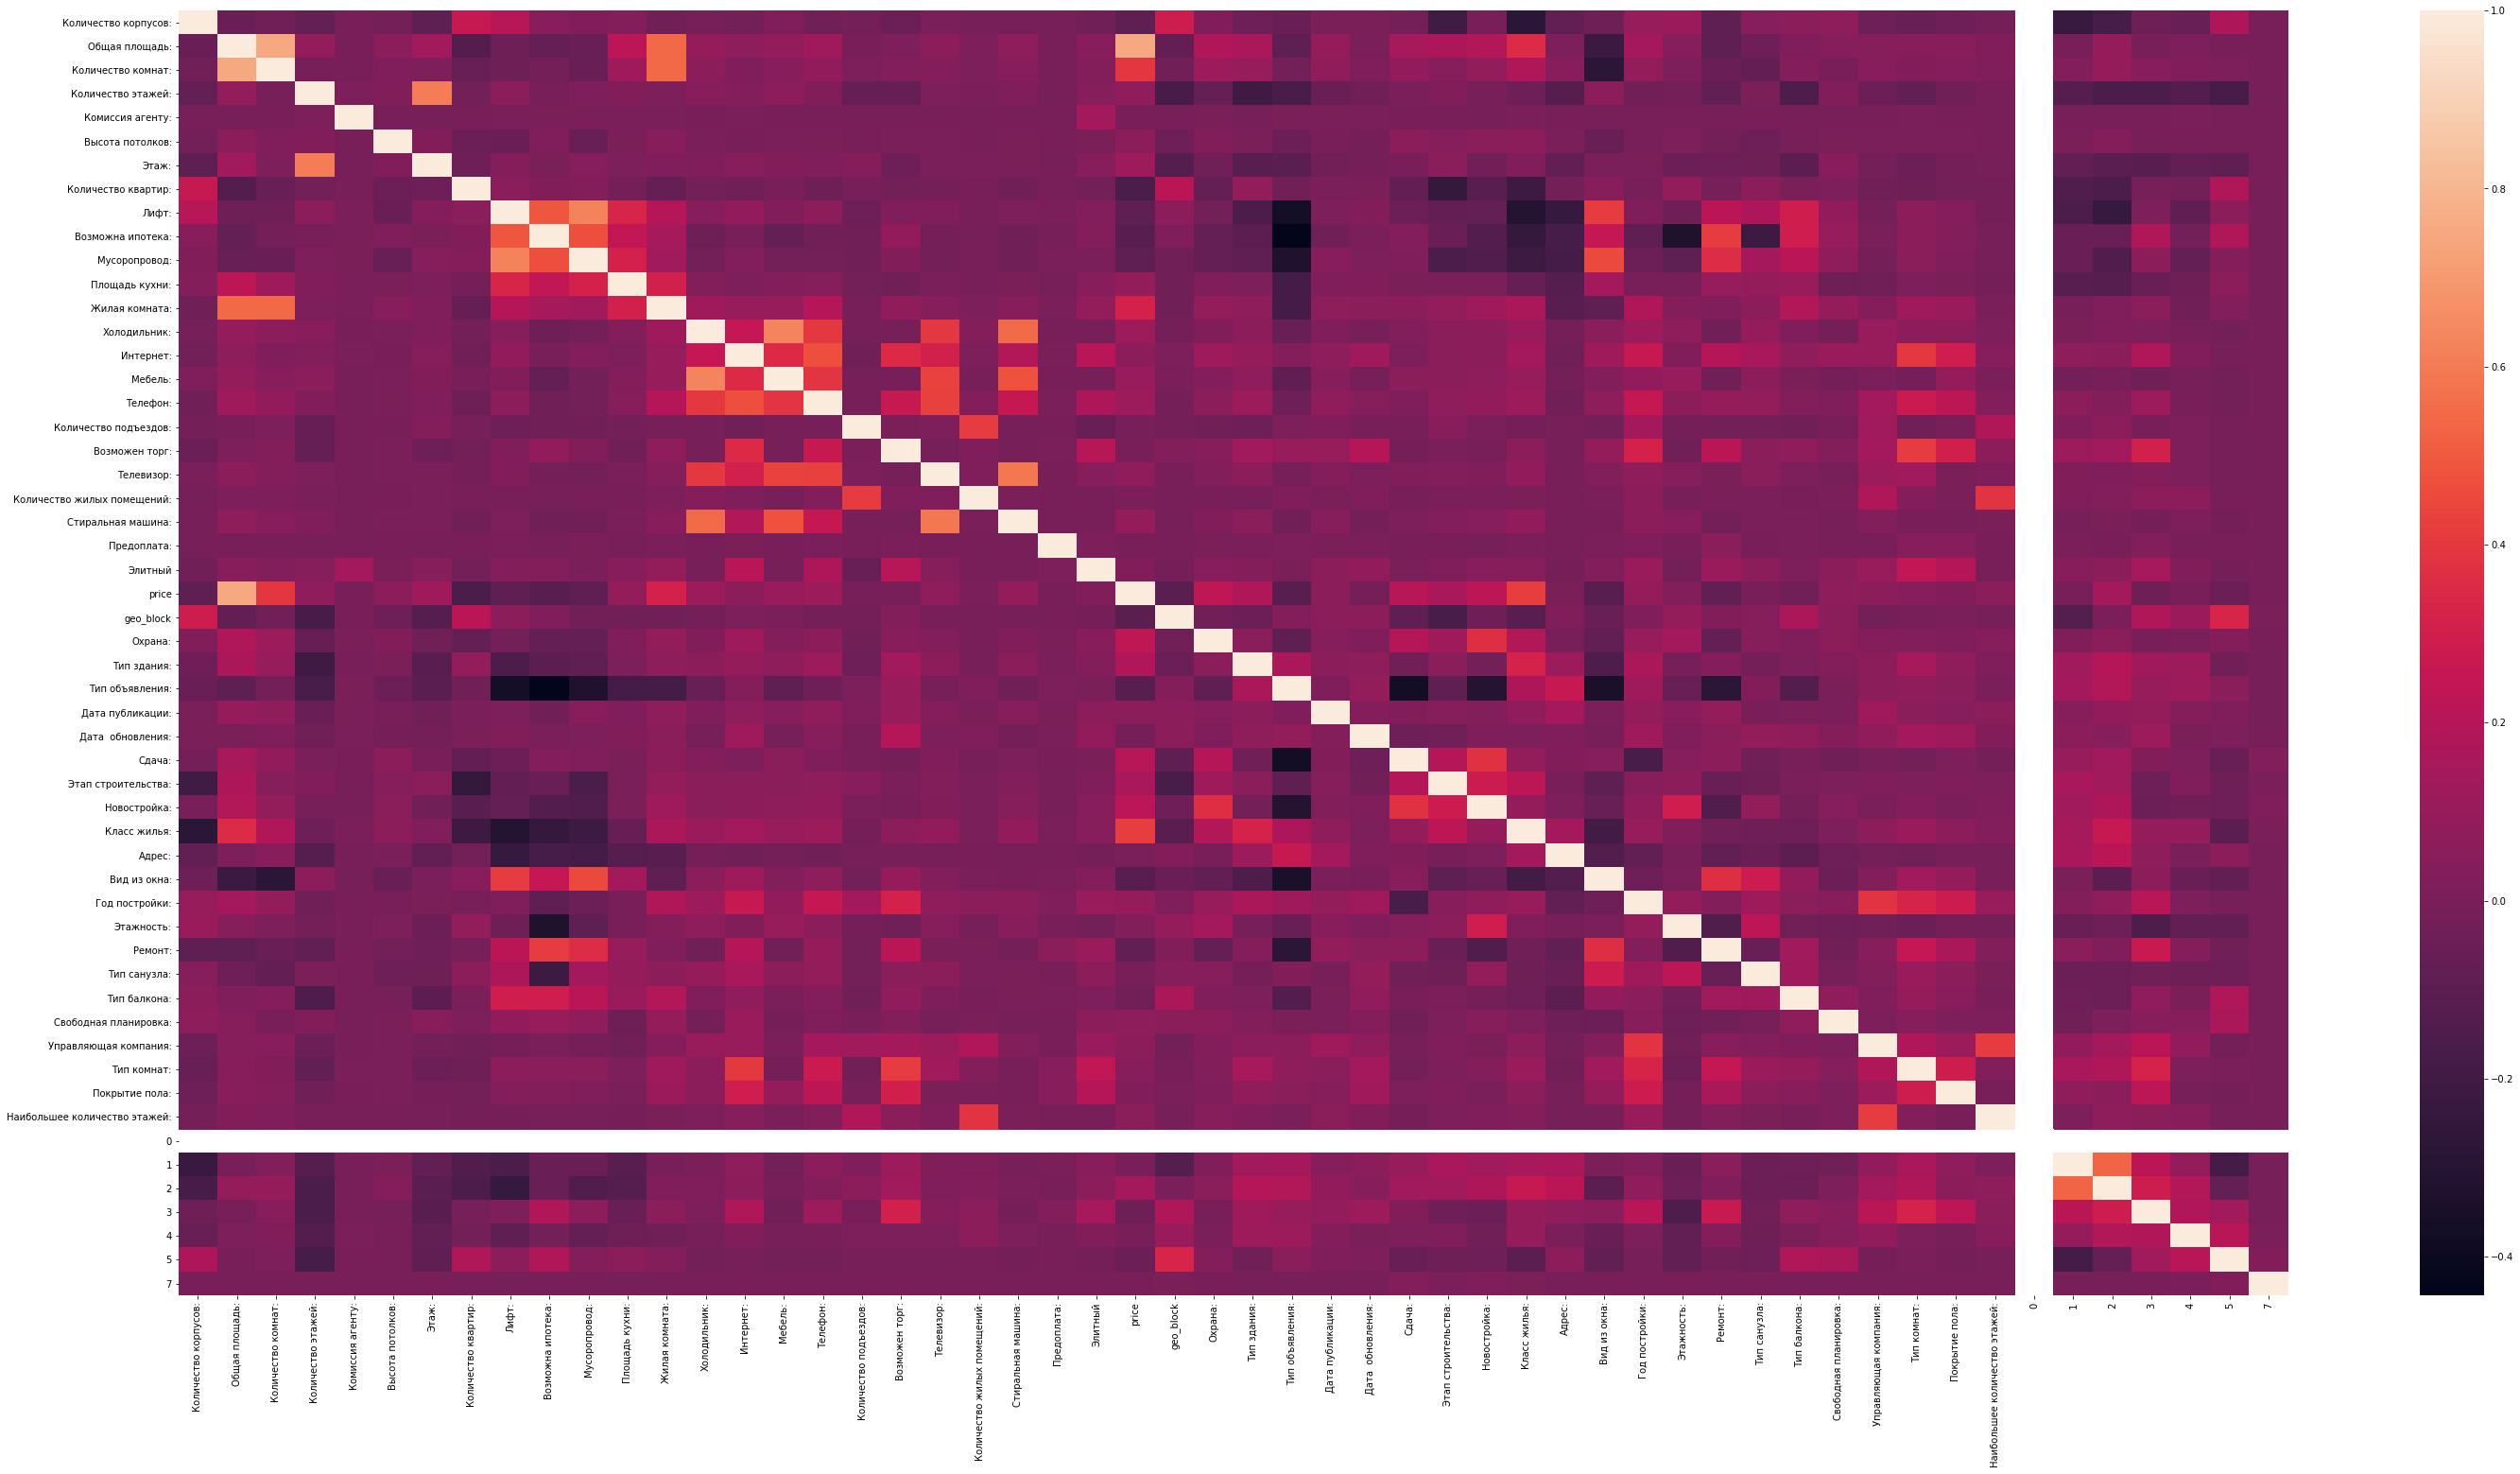

In [318]:
#  Тут я рещил поискать переменные, которые коррелируют между собой

plt.figure(figsize=(50, 25))
sns.heatmap(df_train.corr())

In [312]:
#  Тут я почем зря дропнул переменные, которые коррелировали между собой
#  Не делайте так, если не используете линейную регрессию!

df_num_imputer = df_num_imputer.drop(['Мебель на кухне:'], axis=1)
df_cat = df_cat.drop(['Парковка:', 'Тип перекрытия:', 'Наименьшее количество этажей:', 
                      'Серия:', 'Тип фундамента:'], axis=1)
df = df_num_imputer.merge(df_cat, left_index=True, right_index=True)
df = df.drop(['Класс:', 'Тип объекта:', 'Застройщик:', 'Детская площадка:', 6, 'Тип дома:'], axis=1)

In [317]:
#  Делим трейны и тесты обратно

df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

df_train.shape, df_test.shape

((22729, 54), (11448, 54))

In [321]:
X_train = df_train.drop("price", axis=1)
y_train = df_train["price"]

In [322]:
x_test = df_test.drop("price", axis=1)

In [323]:
from sklearn.model_selection import train_test_split

In [324]:
#  Будем искать оптимальные параметры для модели с помощью Grid 
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [325]:
#  Формируем словарь из параметров, которые хотим перебрать
params = {'min_child_weight': [1, 5, 10],
          'n_estimators' [50, 100, 150],
          'max_depth': [5, 7, 9]
         }

model = xgb.XGBRegressor()

In [328]:
#  тренируем 
clf = GridSearchCV(model, params)

clf.fit(X_train, y_log_train)

In [ ]:
#  Чтобы узнать лучшее решение, нужно выбрать атрибут best_estimator_

clf.best_estimator_

In [319]:
check_log_model(df_train, df_train.columns.drop('price'), clf.best_estimator_)

(2.830534951505872, 0.04691163334224324)

In [326]:
y_log_train = np.log(y_train)

In [333]:
df_test = pd.read_hdf("../input/test_data.h5")

In [331]:
#  Делаем предсказание на логарифме, берем экспоненту, чтобы вернуть в данные обычной цены
y_pred = clf.best_estimator_.predict(x_test)
y_pred = np.exp(y_pred)

In [40]:
#  Упаковываем в датафрейм с айдишками и ценами - это и будет ответ
pd.DataFrame([df_test['id'], y_pred]).T.rename(columns={'Unnamed 0': 'Price'})\
    .astype({'id': 'int'}).to_csv('../output/enriched.csv', index=False)